<a href="https://colab.research.google.com/github/prakharsinghch/QML/blob/main/MODEL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MODEL-2

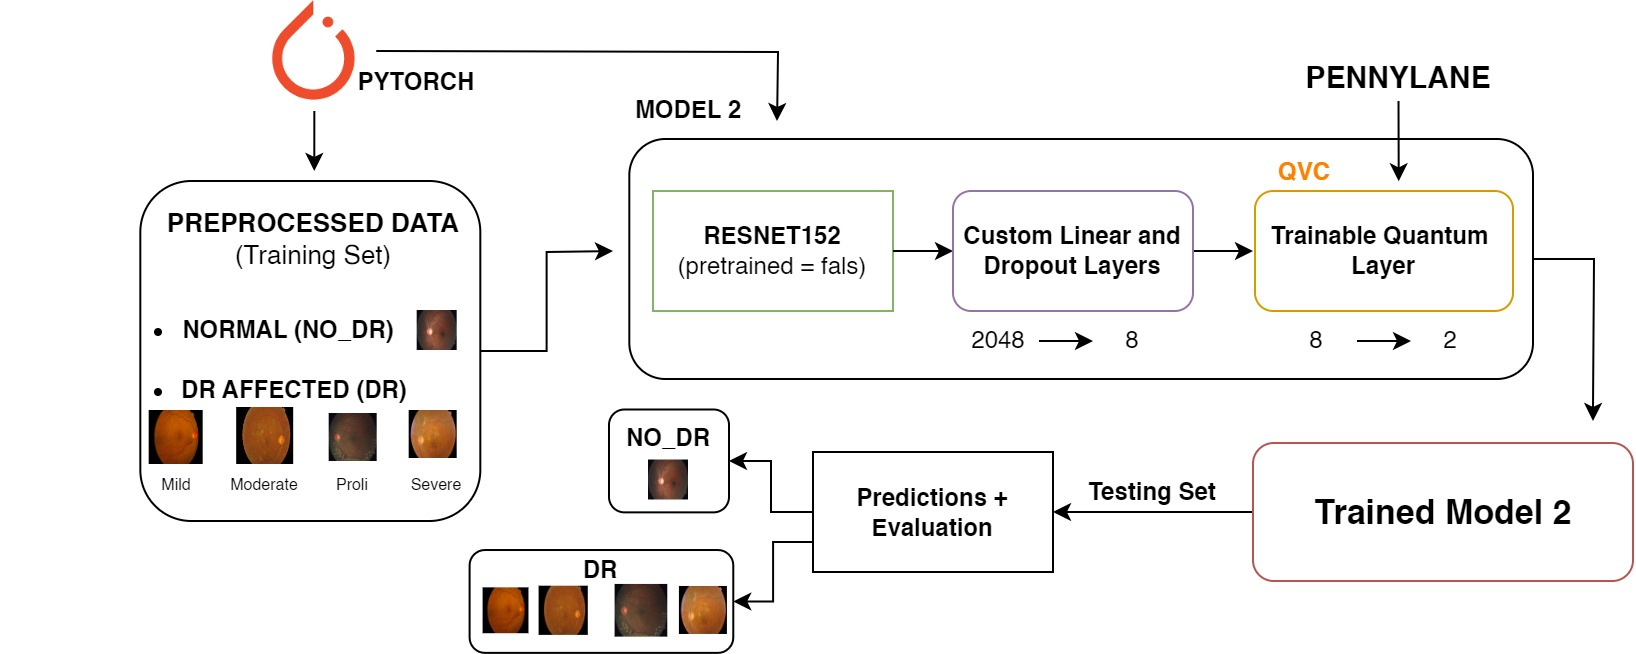

#Importing Dependencies

In [ ]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Dataset Downloading

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data

 98% 233M/238M [00:03<00:00, 86.0MB/s]
100% 238M/238M [00:03<00:00, 81.2MB/s]


In [ ]:
import zipfile
def unzip(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

import os

In [ ]:
unzip("/content/diabetic-retinopathy-224x224-2019-data.zip")

In [ ]:
origin = "/content/colored_images/"

# Formation of Converted Dataset

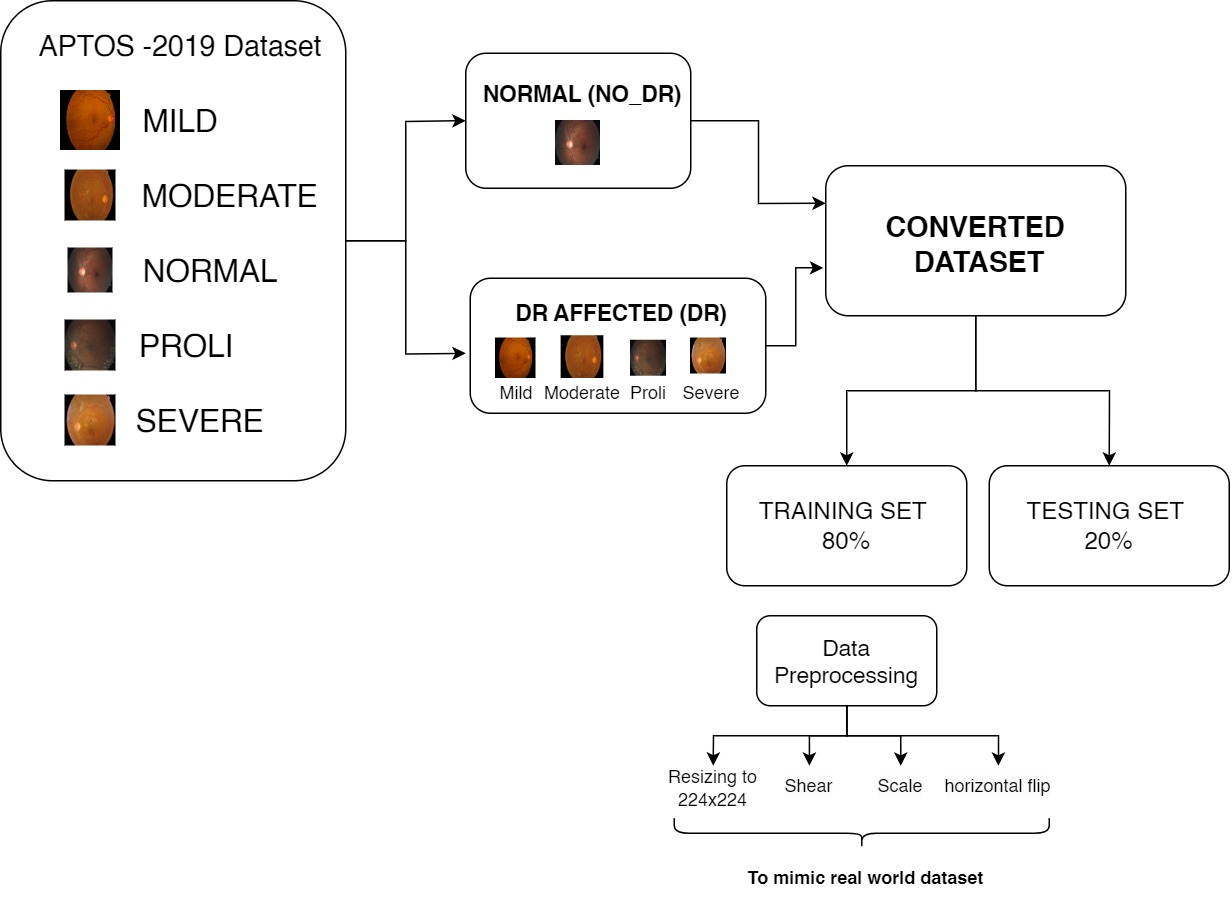

In [ ]:
import shutil, os

os.mkdir('/content/Datasets')
os.mkdir('/content/Datasets/NO_DR')
os.mkdir('/content/Datasets/DR')

In [ ]:
target = "/content/Datasets/DR/"

In [ ]:
files = os.listdir(origin+"/Mild/")

# Fetching all the files to directory
for file_name in files:
   shutil.copy(origin+"/Mild/"+file_name, target)


In [ ]:
files = os.listdir(origin+"/Moderate/")

# Fetching all the files to directory
for file_name in files:
   shutil.copy(origin+"/Moderate/"+file_name, target)


In [ ]:
files = os.listdir(origin+"/Proliferate_DR/")

# Fetching all the files to directory
for file_name in files:
   shutil.copy(origin+"/Proliferate_DR/"+file_name, target)


In [ ]:
files = os.listdir(origin+"/Severe/")

# Fetching all the files to directory
for file_name in files:
   shutil.copy(origin+"/Severe/"+file_name, target)


In [ ]:
target = "/content/Datasets/NO_DR/"
files = os.listdir(origin+"/No_DR/")

# Fetching all the files to directory
for file_name in files:
   shutil.copy(origin+"/No_DR/"+file_name, target)


In [ ]:
import os

def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
walk_through_dir("/content/Datasets")

There are 2 directories and 0 images in '/content/Datasets'.
There are 0 directories and 1805 images in '/content/Datasets/NO_DR'.
There are 0 directories and 1857 images in '/content/Datasets/DR'.


#Dataset Augmentation

In [ ]:
data_path = "/content/Datasets"

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio(data_path, output="/content/Data", seed=42, ratio=(0.8, 0.2))

Copying files: 3662 files [00:02, 1374.30 files/s]


In [ ]:
input_path = "/content/Data/"

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train':
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation':
    datasets.ImageFolder(input_path + 'val', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=1),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=1)  # for Kaggle
}

#Downloading Pennylane and Declaring Hyperparameters

In [ ]:
%%capture
# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib

In [ ]:
import pennylane as qml
from pennylane import numpy as np

In [ ]:
n_qubits = 4                 # Number of qubits
q_depth = 10                 # Depth of the quantum circuit (number of variational layers)
q_delta = 0.01               # Initial spread of random quantum weights
start_time = time.time()

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)  # a simple state simulator of qubit-based quantum circuit architectures provided by pennylane

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Model Creation

#QUANTUM VARIATIONAL CIRCUIT

#Basic Layers for Quantum Circuit

1. Hadamard Gate. No. of Qubits = 10

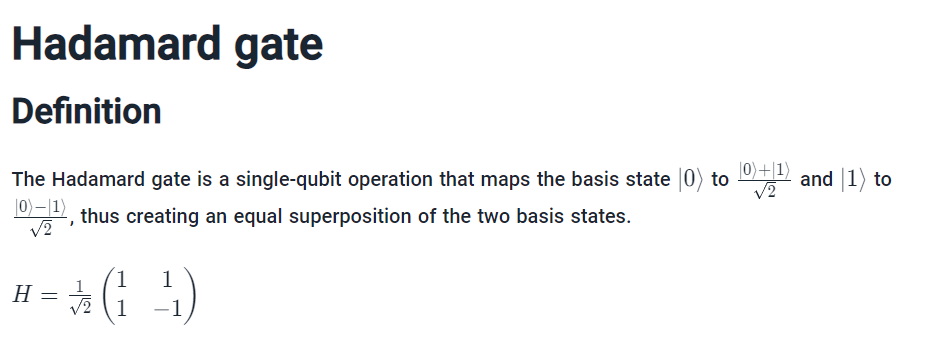

2. Ry Layer

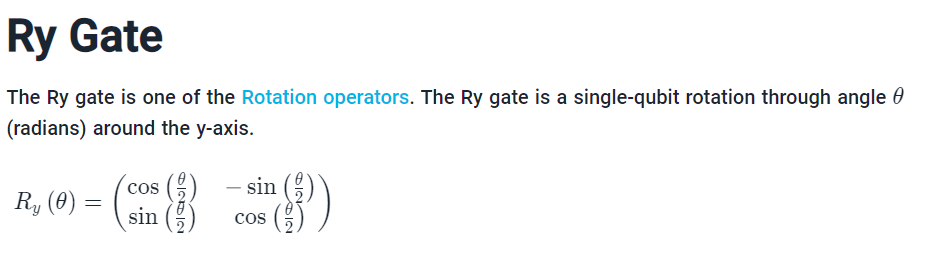

3. Shifted Layer of CNOT Gates

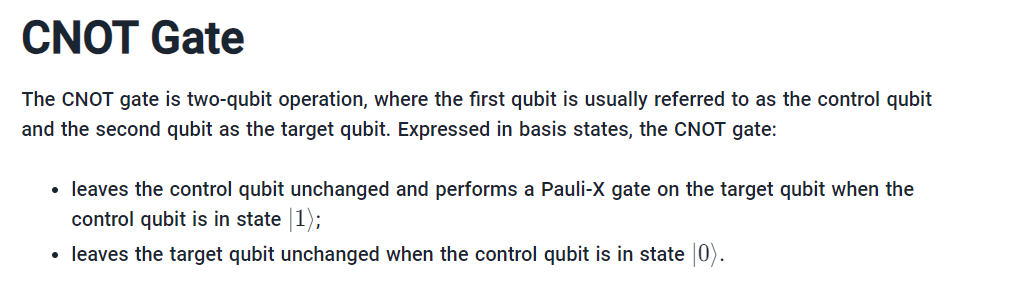





In [ ]:
def H_layer(nqubits):
    """
      Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """
      Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """
      Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])


# PennyLane qnode decorator

The structure is that of a typical variational quantum circuit:

**Embedding layer:** All qubits are first initialized in a balanced superposition of up and down states, then they are rotated according to the input parameters (local embedding).

**Variational layers:** A sequence of trainable rotation layers and constant entangling layers is applied.

**Measurement layer:** For each qubit, the local expectation value of the Z operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [ ]:
@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basisT
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)


#Dressed quantum circuit

We can now define a custom `torch.nn.Module` representing a dressed quantum circuit.

This is a concatenation of:


*   A classical pre-processing layer (nn.Linear).
*   A classical activation function (torch.tanh).
*   A constant np.pi/2.0 scaling.
*   The previously defined quantum circuit (quantum_net).
*   A classical post-processing layer (nn.Linear).

The input of the module is a batch of vectors with **8 real parameters** (features) and the output is a batch of vectors with two real outputs (associated with the two classes of images: **DR and NO_DR**)

In [ ]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()

        self.pre_net = nn.Linear(8,n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)



# Hybrid Classical-Quantum Model

We are finally ready to build our full hybrid classical-quantum network. We follow the transfer learning approach:




1.   First load the classical pre-trained network ResNet152 from the torchvision.models zoo with Resnet-50 weights.
2. Pretrained is set to False, and so PyTorch will not download the pretrained weights.
3. Add your custom layers to the pre-trained model.
4. Replace the last fully connected layer with our trainable dressed quantum circuit (DressedQuantumNet).









In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
model1 = torchvision.models.resnet152(pretrained = False, weights = ResNet50_Weights)

model1.fc = nn.Sequential(
    nn.Linear(2048, 512),
    # nn.Linear(1920,512),
    nn.ReLU(inplace = True),
    nn.Linear(512,256),
    nn.ReLU(inplace = True),
    nn.Linear(256,128),
    nn.Linear(128,64),
    nn.ReLU(inplace = True),
    nn.Linear(64,16),
    # nn.Linear(32,16),
    nn.Linear(16,8),
    DressedQuantumNet()
)


model1.to(device)

#Model Training

In [ ]:
test_acc , train_acc, test_loss, train_loss = [], [], [], []

def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            if(phase == "train"):
                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)

            else:
                test_acc.append(epoch_acc)
                test_loss.append(epoch_loss)

    return model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.fc.parameters())

In [ ]:
model_trained = train_model(model1, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
train loss: 0.4187, acc: 0.8365
validation loss: 0.2709, acc: 0.9332
Epoch 2/20
----------
train loss: 0.2801, acc: 0.9150
validation loss: 0.1960, acc: 0.9523
Epoch 3/20
----------
train loss: 0.2366, acc: 0.9263
validation loss: 0.1775, acc: 0.9495
Epoch 4/20
----------
train loss: 0.2024, acc: 0.9406
validation loss: 0.1862, acc: 0.9359
Epoch 5/20
----------
train loss: 0.1907, acc: 0.9344
validation loss: 0.1487, acc: 0.9563
Epoch 6/20
----------
train loss: 0.1942, acc: 0.9389
validation loss: 0.1523, acc: 0.9632
Epoch 7/20
----------
train loss: 0.1693, acc: 0.9457
validation loss: 0.1371, acc: 0.9604
Epoch 8/20
----------
train loss: 0.1809, acc: 0.9392
validation loss: 0.1286, acc: 0.9618
Epoch 9/20
----------
train loss: 0.1568, acc: 0.9525
validation loss: 0.1206, acc: 0.9632
Epoch 10/20
----------
train loss: 0.1585, acc: 0.9495
validation loss: 0.1462, acc: 0.9563
Epoch 11/20
----------
train loss: 0.1642, acc: 0.9491
validation loss: 0.1186, acc: 0.96

#Plotting Accuracy and Loss Graphs

In [ ]:
te_acc = []

for i in test_acc :
  te_acc.append(i.cpu())

tr_acc = []

for i in train_acc :
  tr_acc.append(i.cpu())


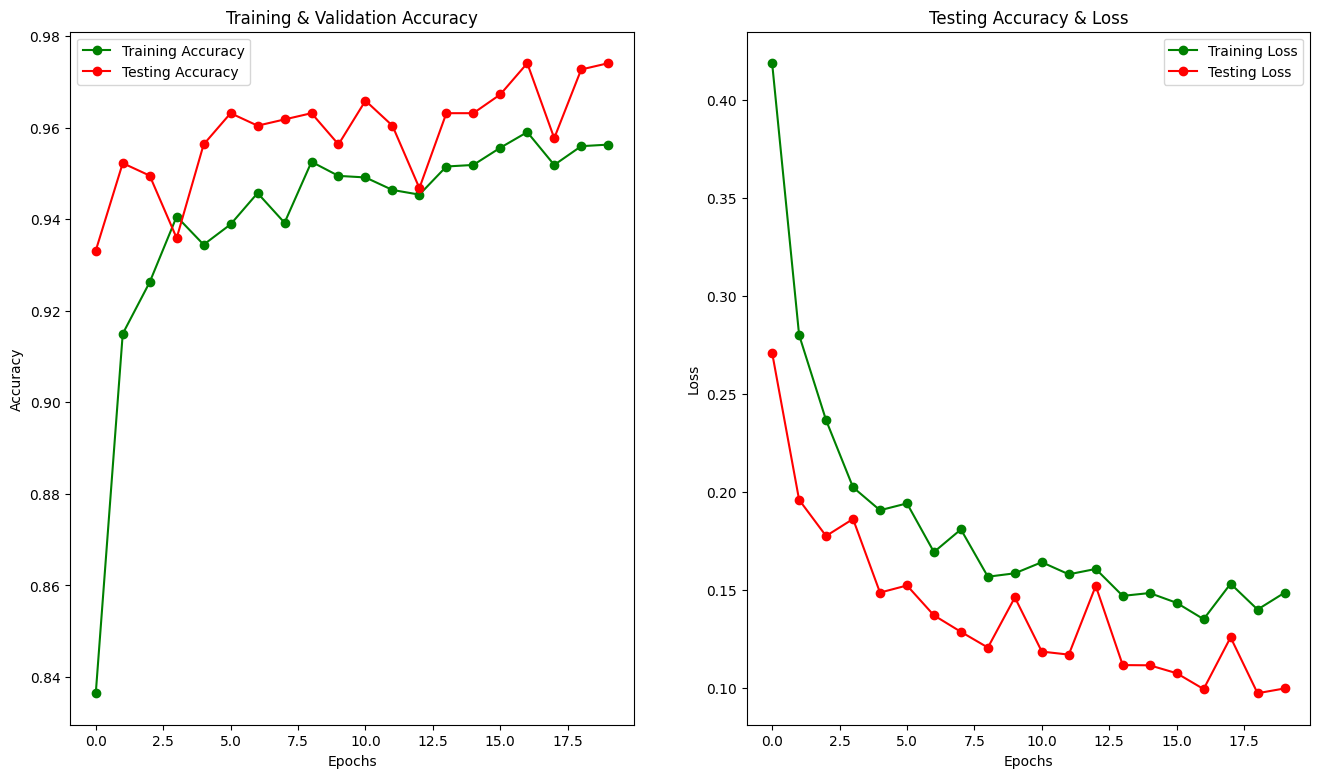

In [ ]:
import matplotlib.pyplot as plt
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = tr_acc
train_loss = train_loss
val_acc = te_acc
val_loss = test_loss
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

#Saving Model to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model1.state_dict(), 'model1_final.pth')

# Confusion Matrix and Classification Metrics

In [ ]:
phase = "validation"

In [ ]:
y_preds = []
label = []

model1.eval()
for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model1(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                y_preds.append(preds.cpu())
                label.append(labels.cpu())

In [ ]:
y_pred = np.array(y_preds[0])
y_true = np.array(label[0])

for i in range(1,len(y_preds)):
  y_pred = np.append(y_pred, np.array(y_preds[i]))

for i in range(1,len(label)):
  y_true = np.append(y_true, np.array(label[i]))



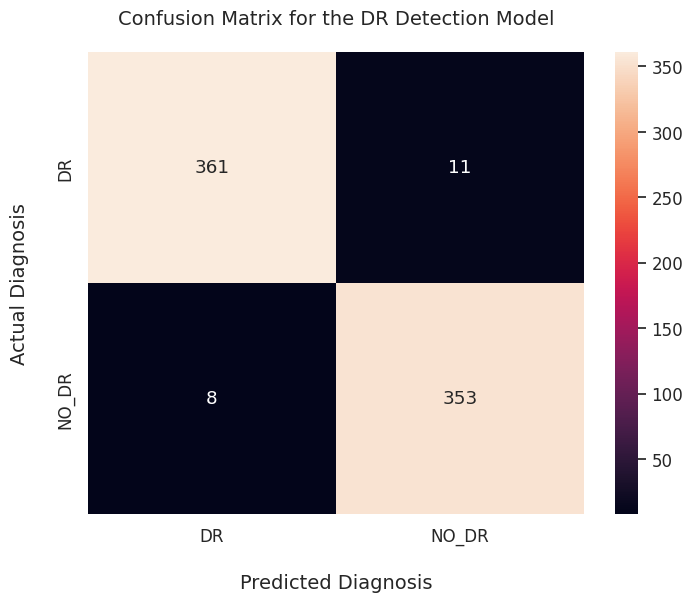

In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_true, y_pred)


import seaborn as sns


plt.figure(figsize=(8,6), dpi=100)

sns.set(font_scale = 1.1)

ax = sns.heatmap(cnf, annot=True, fmt='d', )


ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['DR', 'NO_DR'])

ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['DR', 'NO_DR'])

# set plot title
ax.set_title("Confusion Matrix for the DR Detection Model", fontsize=14, pad=20)

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

classes = ('DR' , 'NO_DR')

print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

          DR       0.98      0.97      0.97       372
       NO_DR       0.97      0.98      0.97       361

    accuracy                           0.97       733
   macro avg       0.97      0.97      0.97       733
weighted avg       0.97      0.97      0.97       733



#Loading Model from Drive

In [ ]:
model2 = torchvision.models.resnet152(pretrained = False, weights = ResNet50_Weights)


for param in model2.parameters():
    param.requires_grad = False



# # # Notice that model_hybrid.fc is the last layer of ResNet18
# model_hybrid.fc = DressedQuantumNet()

# net_add=net()
# model1.fc = net()
# model1 = torch.nn.Sequential(*(list(model1.children())[:-1]))

model2.fc = nn.Sequential(
    nn.Linear(2048, 512),
    # nn.Linear(1920,512),
    nn.ReLU(inplace = True),
    nn.Linear(512,256),
    nn.ReLU(inplace = True),
    nn.Linear(256,128),
    nn.Linear(128,64),
    nn.ReLU(inplace = True),
    nn.Linear(64,16),
    # nn.Linear(32,16),
    nn.Linear(16,8),
    DressedQuantumNet()
)


# model1.fc = DressedQuantumNet()

# # # Use CUDA or CPU according to the "device" object.
# model_hybrid.to(device)
model2.to(device)

In [ ]:
model2.load_state_dict(torch.load('/content/drive/MyDrive/model1_final.pth'))

<All keys matched successfully>

In [ ]:
y_preds = []
label = []

model2.eval()
for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model2(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                y_preds.append(preds.cpu())
                label.append(labels.cpu())

In [ ]:
y_pred = np.array(y_preds[0])
y_true = np.array(label[0])

for i in range(1,len(y_preds)):
  y_pred = np.append(y_pred, np.array(y_preds[i]))

for i in range(1,len(label)):
  y_true = np.append(y_true, np.array(label[i]))



In [ ]:
from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_true, y_pred)

cnf

array([[361,  11],
       [  8, 353]])

#Fetching Predictions from Model

Evaluting the Predicitions

In [ ]:
from PIL import Image

In [ ]:
validation_img_paths = ["val/NO_DR/04efb1a284cc.png",
                        "val/DR/01c7808d901d.png",
                        "val/DR/10fca1abf338.png"]
img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]


In [ ]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [ ]:
pred_logits_tensor = model1(validation_batch)
pred_logits_tensor

tensor([[-1.7995,  1.9180],
        [ 1.9382, -2.4768],
        [ 1.9390, -2.4783]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
pred_probs = torch.nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[0.02371962, 0.9762804 ],
       [0.98805064, 0.01194938],
       [0.9880761 , 0.0119239 ]], dtype=float32)

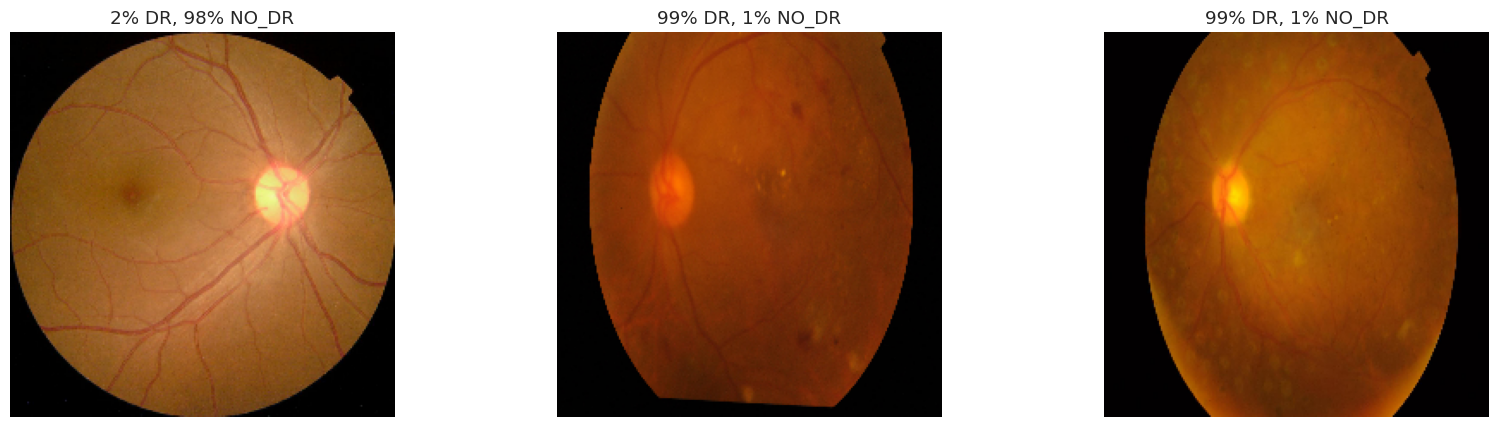

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% DR, {:.0f}% NO_DR".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

#Prediction Function


This quantum circuit, integrated with this model as the backend, has the potential to be part of a full stack application, combining a frontend interface with powerful quantum computations in the backend.

In [ ]:
def fetch_results(validation_img_paths):
  img_list = [Image.open(img_path) for img_path in validation_img_paths]


  validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                  for img in img_list])


  pred_logits_tensor = model1(validation_batch)
  pred_logits_tensor


  pred_probs = torch.nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
  pred_probs

  fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
  for i, img in enumerate(img_list):
      ax = axs[i]
      ax.axis('off')
      ax.set_title("{:.0f}% DR, {:.0f}% NO_DR".format(100*pred_probs[i,0],
                                                              100*pred_probs[i,1]))
      ax.imshow(img)

In [ ]:
validation_img_paths = ["/content/Data/val/DR/12a82fc7d73e.png", "/content/Data/val/NO_DR/0924cec998fa.png" , "/content/Data/val/NO_DR/1f3f32efaf20.png"]

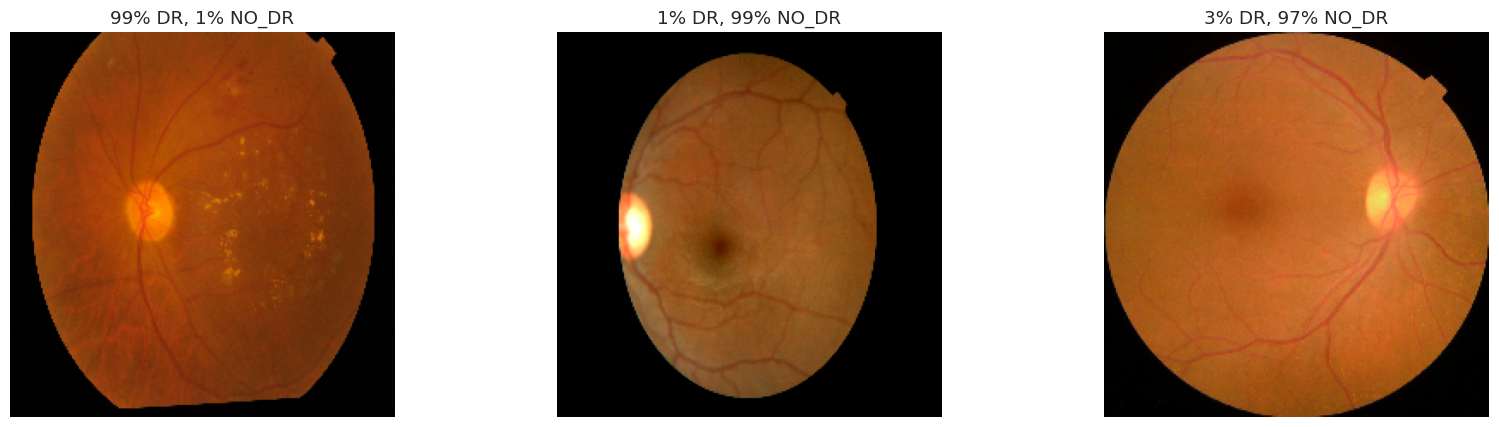

In [ ]:
fetch_results(validation_img_paths)